<div style="text-align: right"> Mark Hendricks </div>

<left>FINM 36700 - Portfolio Theory and Risk Management</left> 
<br>
<left>Fall 2022</left>

<h2><center> Homework 5 - Smart Beta Exchange-Traded Funds and Factor Investing. </center></h2>

<center>Due on Monday, Nov 1</center>

<h3><span style="color:#00008B">Solution - Piyush Kontu</span></h3>

<h3><span style="color:#00008B">Email - pkontu@uchicago.edu</span></h3>

### Smart Beta Exchange-Traded-Funds and Factor Investing.
#### This case is a good introduction to important pricing factors. It also gives useful introduction and context to ETFs, passive vs active investing, and so-called "smart beta" funds.

## 1. The Case

#### <i> This section will not be graded, but it will be discussed in class.</i>

#### 1.1 Describe how each of the factors (other than MKT) is measured.That is, each factor is a portfolio of stocks-which stocks are included in the factor portfolio?

- **Size** - Factor takes a long position on firms with small market capitalizations and a short position on firms with large market capitalizations. The classification of small and large can be based on percentiles,quintiles or deciles. <br><br>

- **Value** - Factor takes a long position on firms with high book-to-market and a short position on firms with low book-to-market. <br><br>

- **Profitability** - Factor takes a long position on firms with high ratio of operating profit to book value and a short position on firms with low ratio of operating profit to book value.<br><br>

- **Investment** - Factor takes a long position on firms with conservative investment and a short position on firms aggresive investment. Investment is measured by the percentage change in the value of firms's asset over the course of a year.<br><br>

- **Momentum** - Factor takes a long position on stocks with large price appreciation in last one year and a short position on firms with price depriciation.<br><br>

#### 1.2 Is the factor portfolio...
- #### long-only
- #### long-short
- #### value-weighted
- #### equally-weighted <br><br>

- All the factors are long-short.<br><br>

- While Size, Value, Profitability and Invetment are generally value-weighted, Momentum is generally equally-weighted.

#### 1.3 What steps are taken in the factor construction to try to reduce the correlation between the factors?

- Creating Long Short portfolios based on deciles of sorted assets. The sorting is done on price or accounting signals that are relatively orthogonal to each other.<br><br>

- Futher the value weighting (using the signal in weighting, for eg - B/M for value factor) also helps keep the correlations relatively lower.

#### 1.4 What is the point of figures 1-6?

- Figures 1-6 depict the return premium exhibited by different quintiles of the sorted assets. <br><br>
- For example - Highest Momentum has a return premium of ~10% over lowest momentum portfolio.

#### 1.5 How is a "smart beta" ETF different from a traditional ETF?

- Smart Beta ETFs are constructed with an emphasis on weighting stocks in the ETF by incorporating into the weighting scheme some aspect of security's fundamental value, such as B/M of a stock for the value factor. <br><br>

- Traditional ETFs simply weight the stocks in the portfolio by their market capitaliztion.

#### 1.6 Is it possible for all investors to have exposure to the "value" factor?

- No, if everyone is exposed to the value factor, the factor premia is driven away and would already be reflected in the Market factor premium.

#### 1.7 How does factor investing differ from traditional diversification?

- In traditional diversification different asset classes such as equities, fixed income, commodities, cash etc. is used to diversify firm specific risk. <br><br>

- In factor investing you diversify your portfolio across factor portfolios (Smart Beta ETFs) so that the investment has some amount in small firm portfolio, some in value portfolio etc in the same asset class.

# Imports

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import kurtosis, skew
from scipy.stats import norm
import seaborn as sns
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set(rc={'figure.figsize':(15, 6)})

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Helper Functions

In [3]:
def performance_summary(return_data):
    """ 
        Returns the Performance Stats for given set of returns
        Inputs: 
            return_data - DataFrame with Date index and Monthly Returns for different assets/strategies.
        Output:
            summary_stats - DataFrame with annualized mean return, vol, sharpe ratio. Skewness, Excess Kurtosis, Var (0.5) and
                            CVaR (0.5) and drawdown based on monthly returns. 
    """
    summary_stats = return_data.mean().to_frame('Mean').apply(lambda x: x*12)
    summary_stats['Volatility'] = return_data.std().apply(lambda x: x*np.sqrt(12))
    summary_stats['Sharpe Ratio'] = summary_stats['Mean']/summary_stats['Volatility']
    
    summary_stats['Skewness'] = return_data.skew()
    summary_stats['Excess Kurtosis'] = return_data.kurtosis()
    summary_stats['VaR (0.5)'] = return_data.quantile(.05, axis = 0)
    summary_stats['CVaR (0.5)'] = return_data[return_data <= return_data.quantile(.05, axis = 0)].mean()
    
    wealth_index = 1000*(1+return_data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks

    summary_stats['Max Drawdown'] = drawdowns.min()
    summary_stats['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
    summary_stats['Bottom'] = drawdowns.idxmin()
    
    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][:drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin():]]).T
        recovery_date.append(recovery_wealth[recovery_wealth[col] >= prev_max].index.min())
    summary_stats['Recovery'] = recovery_date
    
    return summary_stats

In [4]:
def regression_based_performance(factor,fund_ret,rf,constant = True):
    """ 
        Returns the Regression based performance Stats for given set of returns and factors
        Inputs:
            factor - Dataframe containing monthly returns of the regressors
            fund_ret - Dataframe containing monthly excess returns of the regressand fund
            rf - Monthly risk free rate of return
        Output:
            summary_stats - (Beta of regression, treynor ratio, information ratio, alpha). 
    """
    if constant:
        X = sm.tools.add_constant(factor)
    else:
        X = factor
    y=fund_ret
    model = sm.OLS(y,X,missing='drop').fit()
    
    if constant:
        beta = model.params[1:]
        alpha = round(float(model.params['const']),6) *12

        
    else:
        beta = model.params
    treynor_ratio = ((fund_ret - rf).mean()*12)/beta[0]
    tracking_error = (model.resid.std()*np.sqrt(12))
    if constant:        
        information_ratio = model.params[0]*12/tracking_error
    r_squared = model.rsquared
    if constant:
        return (beta,treynor_ratio,information_ratio,alpha,r_squared,tracking_error,model.resid)
    else:
        return (beta,treynor_ratio,r_squared,tracking_error,model.resid)

In [5]:
def tangency_portfolio_rfr(asset_return,cov_matrix):
    """ 
        Returns the tangency portfolio weights in a (1 x n) vector when a riskless assset is available
        Inputs: 
            asset_return - Excess return over the risk free rate for each asset (n x 1) Vector
            cov_matrix = nxn covariance matrix for the assets
    """
    asset_cov = np.array(cov_matrix)
    inverted_cov= np.linalg.inv(asset_cov)
    one_vector = np.ones(len(cov_matrix.index))
    
    den = (one_vector @ inverted_cov) @ (asset_return)
    num =  inverted_cov @ asset_return
    return (1/den) * num

In [6]:
def rolling_regression_param(factor,fund_ret,roll_window = 60):
    """ 
        Returns the Rolling Regression parameters for given set of returns and factors
        Inputs:
            factor - Dataframe containing monthly returns of the regressors
            fund_ret - Dataframe containing monthly excess returns of the regressand fund
            roll_window = rolling window for regression
        Output:
            params - Dataframe with time-t as the index and constant and Betas as columns
    """
    X = sm.add_constant(factor)
    y= fund_ret
    rols = RollingOLS(y, X, window=roll_window)
    rres = rols.fit()
    params = rres.params.copy()
    params.index = np.arange(1, params.shape[0] + 1)
    return params
    

In [46]:
def oos_rsquare(factors,port_ret,rolling_window = 60):
    """ 
        Returns the OOS R-Squared for a rolling regression(prediction) and expanding mean (baseline) 
        from given set of returns and factors
        Inputs:
            factors - Dataframe containing monthly returns of the regressors
            port_ret - Dataframe containing monthly excess returns of the regressand portfolios
            roll_window = rolling window for regression
        Output:
            Dataframe with OOS R-Squared for each of the portfolios in port_ret
    """
    factor_exp = factors.expanding().mean()
    portfolios = port_ret.columns
    df_roll = []
    for port in portfolios:
        fund_ret = port_ret[port]
        reg = rolling_regression_param(factors,fund_ret,60) 
        port_betas = reg.dropna()[factors.columns]
        port_betas.index = factor_exp[port_betas.index[0]-1:].index
        rollin_reg_predict = (port_betas * factor_exp[port_betas.index[0]:]).sum(axis=1).shift(1).dropna()
        exp_means_predict = fund_ret.expanding().mean().shift(1).loc[rollin_reg_predict.index[0]:]

        mse_forecast = ((rollin_reg_predict - fund_ret.loc[rollin_reg_predict.index[0]:])**2).sum()
        mse_baseline = ((exp_means_predict - fund_ret.loc[rollin_reg_predict.index[0]:])**2).sum()

        OOS_RSquared = 1-(mse_forecast/mse_baseline)
        df_roll.append(pd.DataFrame([[OOS_RSquared]],columns=['OOS R-Squared'],index = [port]))

    return pd.concat(df_roll)


# Reading Data

In [7]:
factors = pd.read_excel(r'C:\Users\piyus\Documents\Repos\finm-portfolio-2022\data\factor_pricing_data.xlsx',sheet_name = 'factors (excess returns)')
factors = factors.set_index('Date')
factors.head()

,MKT,SMB,HML,RMW,CMA,UMD
Date,,,,,,
1980-01-31,0.0551,0.0183,0.0175,-0.0170,0.0164,0.0755
1980-02-29,-0.0122,-0.0157,0.0061,0.0004,0.0268,0.0788
1980-03-31,-0.1290,-0.0693,-0.0101,0.0146,-0.0119,-0.0955
1980-04-30,0.0397,0.0105,0.0106,-0.0210,0.0029,-0.0043
1980-05-31,0.0526,0.0211,0.0038,0.0034,-0.0031,-0.0112


In [22]:
port_ret = pd.read_excel(r'C:\Users\piyus\Documents\Repos\finm-portfolio-2022\data\factor_pricing_data.xlsx',sheet_name = 'portfolios (excess returns)')
port_ret = port_ret.set_index('Date')
port_ret.head()


,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
Date,,,,,,,,,,,,,,,,,,,,,
1980-01-31,-0.0050,0.0283,0.0084,0.1024,-0.0143,0.0999,0.0354,0.0352,0.0048,0.0032,...,0.0159,0.0876,0.0463,-0.0116,0.0458,-0.0279,0.0258,0.0751,0.0299,0.0665
1980-02-29,0.0111,-0.0610,-0.0966,-0.0319,-0.0569,-0.0314,-0.0527,-0.0788,-0.0556,-0.0140,...,-0.0079,-0.0535,-0.0339,-0.0633,-0.0638,-0.0855,-0.0960,-0.0314,-0.0275,-0.0267
1980-03-31,-0.2244,-0.1116,-0.0167,-0.1464,-0.0192,-0.1281,-0.0817,-0.1278,-0.0565,-0.0664,...,-0.0821,-0.1511,-0.1106,-0.0922,-0.1443,-0.0563,-0.0883,-0.2441,-0.1245,-0.1728
1980-04-30,0.0451,0.0766,0.0232,0.0305,0.0831,-0.0521,0.0775,0.0182,0.0304,0.0113,...,0.0419,-0.0097,-0.0300,0.0351,0.0522,0.0729,0.0532,0.0997,0.0448,0.0762
1980-05-31,0.0637,0.0792,0.0457,0.0895,0.0814,0.0512,0.0324,0.0876,0.0560,0.0064,...,0.0565,0.1060,0.1147,0.0868,0.1127,0.0577,0.0557,0.1040,0.0839,0.0684


## 2. The Factors

#### Use the data found in "factor pricing data.xlsx".
- #### FACTORS: Monthly excess return data for the overall equity market, $\tilde{r}^{MKT}$. The sheet also contains data on five additional factors. All factor data is already provided as excess returns.

### 2.1) Analyze the factors, similar to how you analyzed the three Fama-French factors in Homework 4. You now have three additional factors, so let's compare there univariate statistics.

- ### mean
- ### volatility
- ### Sharpe

In [8]:
factor_summary = performance_summary(factors)
factor_summary.loc[:,['Mean','Volatility','Sharpe Ratio','VaR (0.5)','CVaR (0.5)']]

,Mean,Volatility,Sharpe Ratio,VaR (0.5),CVaR (0.5)
MKT,0.083123,0.156687,0.530507,-0.074085,-0.103181
SMB,0.012169,0.100518,0.121061,-0.041860,-0.057242
HML,0.027523,0.108816,0.252929,-0.041945,-0.065731
RMW,0.044845,0.083410,0.537649,-0.028485,-0.050665
CMA,0.033260,0.071503,0.465159,-0.026735,-0.038588
UMD,0.065513,0.154486,0.424069,-0.068145,-0.107323


In [13]:
sub_samples = {
              '1926-1980' : ['1926','1980'],
              '1981-2001' : ['1981','2001'],
              '2002-2022' : ['2002','2022'],
              }

sub_summary = []
for k,v in sub_samples.items():
    sub_sample = factors.loc[sub_samples[k][0]:sub_samples[k][1]]
    sub_sample_summary = performance_summary(sub_sample)
    sub_sample_summary = sub_sample_summary.loc[:,['Mean','Volatility','Sharpe Ratio','VaR (0.5)','CVaR (0.5)']]
    sub_sample_summary['Period'] = k
    sub_sample_summary= sub_sample_summary.reset_index().rename(columns = {'index':'Factor'}).set_index(['Period','Factor'])
    sub_summary.append(sub_sample_summary)

sub_summary_df = pd.concat(sub_summary)
sub_summary_df

Mean  Volatility  Sharpe Ratio  VaR (0.5)  CVaR (0.5)
Period    Factor                                                           
1926-1980 MKT     0.202900    0.203717      0.995990  -0.082910   -0.129000
          SMB     0.053700    0.108821      0.493472  -0.049390   -0.069300
          HML    -0.198700    0.117754     -1.687412  -0.072740   -0.083300
          RMW     0.107800    0.073037      1.475957  -0.018800   -0.021000
          CMA    -0.097700    0.076936     -1.269882  -0.040650   -0.056600
          UMD     0.307800    0.234594      1.312054  -0.079715   -0.095500
1981-2001 MKT     0.077257    0.157396      0.490847  -0.064545   -0.101262
          SMB     0.001433    0.109694      0.013067  -0.043500   -0.062193
          HML     0.063729    0.111276      0.572706  -0.041790   -0.060523
          RMW     0.046910    0.091743      0.511312  -0.030260   -0.057392
          CMA     0.053114    0.077273      0.687356  -0.029880   -0.041077
          UMD     0.101686    0.145105      0.700775  -0.060980   -0.092246
2002-2022 MKT     0.083289    0.153972      0.540933  -0.078795   -0.098869
          SMB     0.021068    0.090137      0.233731  -0.039485   -0.048069
          HML     0.001679    0.104507      0.016066  -0.041000   -0.063864
          RMW     0.039702    0.074726      0.531296  -0.026435   -0.043723
          CMA     0.019423    0.064240      0.302346  -0.023830   -0.032038
          UMD     0.017032    0.158055      0.107762  -0.071090   -0.120015

### 2.2) Based on the factor statistics above, answer the following.

### 2.2.a) Does each factor have a positive risk premium (positive expected excess return)?

Each factor does display positive risk premia, with the Market Factor having the highest excess returns and the Size factor having the lowest premia. Momemtum also emerges out as one of the most compelling factors posting an average annual risk premia of ~6.5%.

### 2.2.b) How have the factors performed since the time of the case, (2015-present)?

Between 2015 and 2022, we observe that Size, and Value factors have fallen out of favor and have posted negative risk premia. Value Factor especially had significant underperformance as it is in a deep drawdown since the recovery post the Tech bubble burst. Technology disruption in 2010s and longer bull runs and recoveries aftor financial crises of 2008 and 2020, have led to companies trading farther away from their fundamentals, turning the value factor into a losing bet.  However, with 2022 being one of the worst performing years since 2008, value factor has started to show signs of revival.

Emergence of prominent tech stocks who invest aggresively in their projects and their outperformance majorly from the momentum factor, has also led Investment factor (CMA) to post negative risk premia.

In [14]:
sub_2015 = factors.loc['2015':]
factor_summary_2015 = performance_summary(sub_2015)
factor_summary_2015.loc[:,['Mean','Volatility','Sharpe Ratio','VaR (0.5)','CVaR (0.5)','Max Drawdown']]

,Mean,Volatility,Sharpe Ratio,VaR (0.5),CVaR (0.5),Max Drawdown
MKT,0.106943,0.160183,0.667635,-0.078825,-0.09796,-0.220039
SMB,-0.005765,0.097683,-0.059020,-0.041940,-0.05266,-0.256376
HML,-0.019709,0.132493,-0.148753,-0.048185,-0.07774,-0.513348
RMW,0.039535,0.071200,0.555262,-0.023310,-0.03332,-0.097615
CMA,0.002243,0.079622,0.028177,-0.026680,-0.04164,-0.211217
UMD,0.025526,0.136844,0.186534,-0.064415,-0.08616,-0.250697


### 2.3) Report the correlation matrix across the six factors.

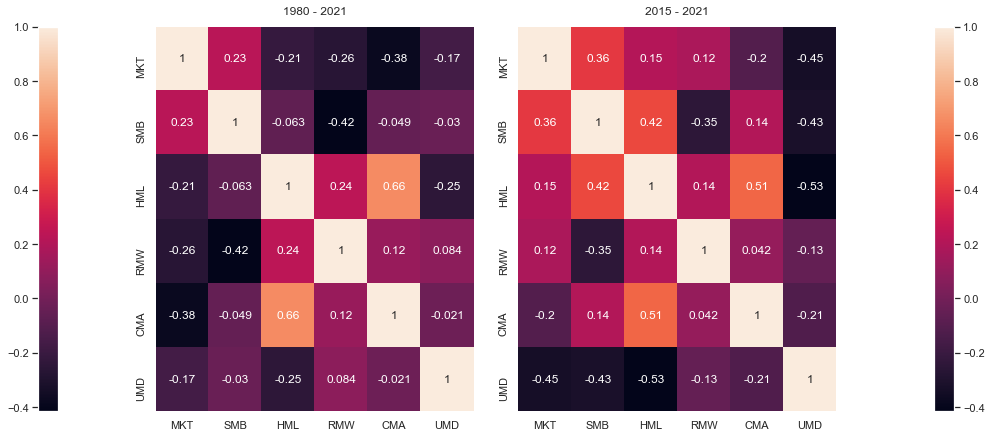

In [10]:
fig, (ax,ax2) = plt.subplots(ncols=2)

fig.subplots_adjust(wspace=0.01)
fig.tight_layout(pad=1)
sns.heatmap(factors.corr(), ax=ax, cbar=False, annot = True).set_title('1980 - 2021', fontdict={'fontsize':12}, pad=12);

fig.colorbar(ax.collections[0], ax=ax,location="left", use_gridspec=False, pad=0.2)
sns.heatmap(sub_2015.corr(), ax=ax2, cbar=False, annot = True).set_title('2015 - 2021', fontdict={'fontsize':12}, pad=12);

fig.colorbar(ax.collections[0],ax=ax2,location="right", use_gridspec=False, pad=0.2)

fig.set_figwidth(15)
plt.show()

### 2.3.a) Does the construction method succeed in keeping correlations small?

The correlations across most factors are low as intended by the factor investing thesis, however we observe that CMA and HML have really high correlation compared to others. This result is consistent to the common belief that firms with high book to market value tend to be firms with a conservative investment strategy.

The correlation of the value factor with the momentum factor is significantly negative. This result may not come as a surprise given that in general value stocks, with high book to market value, are so because of their dim future. Most investors would be willing to pay a higher market price for winning stocks than they would for stocks losing in short term. 

### 2.3.b) Fama and French say that HML is somewhat redundant in their 5-factor model. Does this seem to be the case?

The redundancy of HML in the 5 factor model means that its average return is fully captured by its exposures to the other factors of the five-factor model. Given the high correlation of HML with CMA and a decent correlation with RMW, the addition of these two factors would introduce multicollienearity in the regression and might lead to a very low beta for HML, making it redundant in the 5 factor model.

### 2.4) Report the tangency weights for a portfolio of these 6 factors.

In [15]:
mean_excess_ret =  np.array(factor_summary['Mean'])

tangency_port = tangency_portfolio_rfr(mean_excess_ret,factors.cov())

TangencyPort_df = pd.DataFrame(tangency_port,columns= ["Tangency Portfolio Weight"],index=factor_summary.index)
TangencyPort_df.T

,MKT,SMB,HML,RMW,CMA,UMD
Tangency Portfolio Weight,0.201062,0.081551,-0.047037,0.288377,0.377449,0.098597


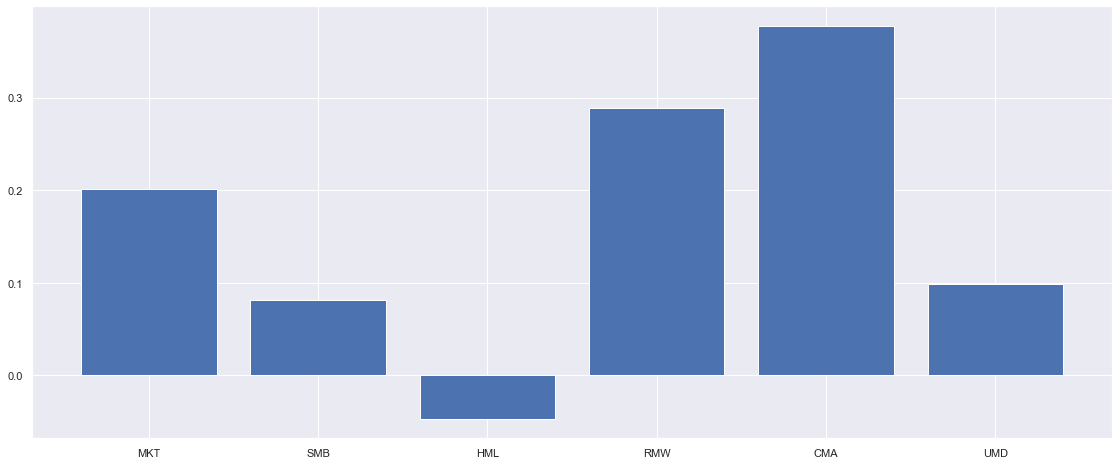

In [16]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(TangencyPort_df.index,TangencyPort_df['Tangency Portfolio Weight'])
plt.show()

### 2.4.a) Which factors seem most important? And Least?

The Tangency portfolio is takes heavy long positions on RMW, CMA and MKT, while shorting the HML and low weights on UMD and SMB. this indicates that the value factor might be the least useful, which was also indicated by Fama-French in their 5 factor model. Also according to a recent study by AQR Capital Management (https://www.aqr.com/Insights/Perspectives/There-is-No-Size-Effect-Daily-Edition), the size premia only exists in conjunction with the market beta factor.

The Market factor and Quality factors i.e. Profitability and Investments seem to be of the most importance in this portfolio.

### 2.4.b) Are the factors with low mean returns still useful?

The factors like SMB and CMA post low returns, but are still useful in the tangency portfolio due to their low correlations with other factors in the portfolio. However, HML, which also posted low returns in the sample period, is becoming redundant not because of its low returns but due to its high correlations with CMA, which is penalized by the tangency portfolio and MVO.

### 2.4.c) Re-do the tangency portfolio, but this time only include MKT, SMB, HML, and UMD. Which factors get high/low tangency weights now?

Once the CMA factor, which was largely correlated with HML, is taken out of the tangency portfolio, Value factor emerges out to be of the most significant as it has really low correlations with the remaining factors. HML and RMW had the 2nd highest correlation previously, and removal of RMW also contributes to a larger weight for HML in the tangency portfolio.

SMB now has the highest correlation between the 4 factors with MKT and thus is penalized for it and has the lowest weight in the tangency portfolio

In [17]:
mean_excess_ret_4factor =  np.array(factor_summary['Mean'].drop(['RMW','CMA']))

tangency_port_4factor = tangency_portfolio_rfr(mean_excess_ret_4factor,factors.drop(['RMW','CMA'],axis = 1).cov())

tangency_port_4factor = pd.DataFrame(tangency_port_4factor,columns= ["Tangency Portfolio Weight"],index=factor_summary['Mean'].drop(['RMW','CMA']).index)
tangency_port_4factor.T



,MKT,SMB,HML,UMD
Tangency Portfolio Weight,0.331433,0.006051,0.362221,0.300295


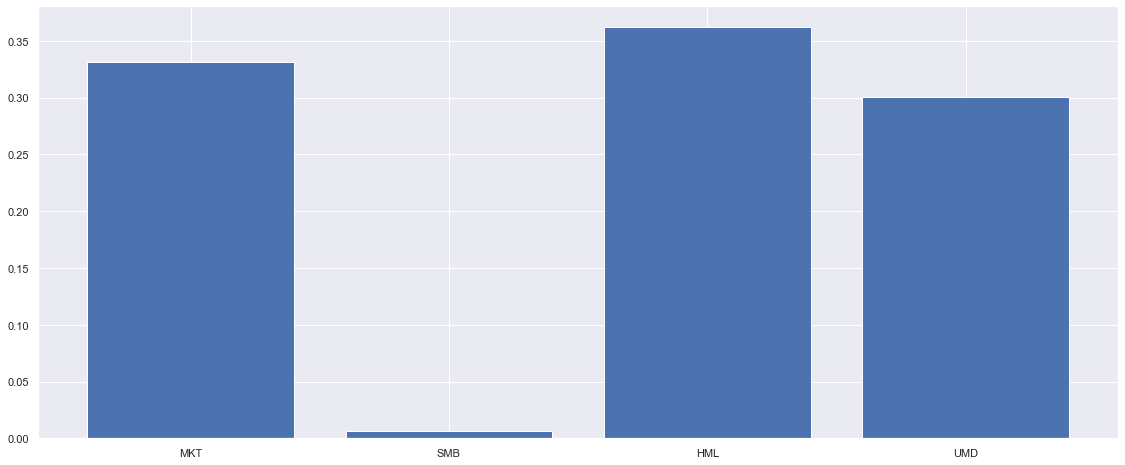

In [18]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(tangency_port_4factor.index,tangency_port_4factor['Tangency Portfolio Weight'])
plt.show()

### What do you conclude about the importance or unimportance of these styles?

All these style factors can come in handy for both a linear factor decomposition and in a linear pricing model, as long as the combination of these factors do not posit heavy correlations. All the factors have posted positive risk premia for a longer duration, but due regime changes and changes in market microstructure resulting from advancing technologies and changing investor behavior, some factors might now prove to be redundant or might not display positive risk premia for a longer duration. 

## 3. Testing Modern LPMs

#### Consider the following factor models:
- #### CAPM: MKT
- #### Fama-French 3F: MKT, SMB, HML
- #### Fama-French 5F: MKT, SMB, HML, RMW, CMA
- #### AQR: MKT, HML, RMW, UMD

#### For instance, for the AQR model

#### <center>$\mathop{\mathbb{E}}[\tilde{r}^{i}] = \beta^{i,\text{MKT}} \mathop{\mathbb{E}}[\tilde{f}^{\text{MKT}}] + \beta^{i,\text{HML}} \mathop{\mathbb{E}}[\tilde{f}^{\text{HML}}] + \beta^{i,\text{RMW}} \mathop{\mathbb{E}}[\tilde{f}^{\text{RMW}}] + \beta^{i,\text{UMD}} \mathop{\mathbb{E}}[\tilde{f}^{\text{UMD}}]$</center>

#### We will test these models with the time-series regressions. Namely, for each asset i, estimate the following regression to test the AQR model:

####   <center> $\tilde{r}_{t}^{i}$ = $α^{i} + β^{\text{i,MKT}}\tilde{f}^{\text{MKT}}_{t} + β^{\text{i,HML}}\tilde{f}^{\text{HML}}_{t} + β^{\text{i,RMW}}\tilde{f}^{\text{RMW}}_{t} + β^{\text{i,UMD}}\tilde{f}^{\text{UMD}}_{t} + ε_{t}$ </center>

#### So you are running that regression n times, once for each security, $\tilde{r}^{i}$.
### Data

- #### PORTFOLIOS: Monthly excess return data on 49 equity portfolios sorted by their industry. Denote these as $\tilde{r}^{i}$, for n = 1,....,49.
- #### You do NOT need the risk-free rate data. It is provided only for completeness. The other two tabs are already in terms of excess returns.

In [23]:
ind_port_summary = performance_summary(port_ret)
ind_port_summary.loc[:,['Mean','Volatility','Sharpe Ratio','VaR (0.5)','CVaR (0.5)']].T

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
Mean,0.092855,0.102267,0.110805,0.119684,0.132612,0.065130,0.111820,0.073202,0.082650,0.101620,...,0.093909,0.088495,0.083391,0.111579,0.100580,0.090851,0.097554,0.046793,0.109896,0.047960
Volatility,0.216429,0.150648,0.220438,0.170352,0.223802,0.247819,0.260247,0.204616,0.152447,0.221567,...,0.197777,0.196060,0.179393,0.187139,0.181478,0.212241,0.182212,0.249699,0.222298,0.219957
Sharpe Ratio,0.429031,0.678847,0.502660,0.702567,0.592540,0.262814,0.429670,0.357755,0.542156,0.458644,...,0.474825,0.451369,0.464848,0.596237,0.554224,0.428054,0.535386,0.187397,0.494363,0.218043
VaR (0.5),-0.090075,-0.060490,-0.094625,-0.068835,-0.092830,-0.108030,-0.108255,-0.083840,-0.066395,-0.098695,...,-0.087125,-0.085750,-0.077475,-0.078280,-0.075620,-0.093485,-0.076250,-0.097495,-0.105735,-0.097845
CVaR (0.5),-0.128196,-0.090642,-0.139069,-0.104373,-0.140542,-0.154727,-0.177623,-0.121646,-0.097792,-0.138946,...,-0.129792,-0.122635,-0.112888,-0.109781,-0.116231,-0.141735,-0.120496,-0.164996,-0.145623,-0.147896


### 3.1) Test the AQR 4-Factor Model using the time-series test. (We are not doing the cross-sectional regression tests.)

### 3.1.a) For each regression, report the estimated α and r-squared.

In [24]:
portfolios = port_ret.columns
factor_aqr = factors.drop(['SMB','CMA'],axis = 1)
df_lst_aqr= []
for port in portfolios:
    fund_ret = port_ret[port]
    reg = regression_based_performance(factor_aqr,fund_ret,0)
    beta_mkt = reg[0][0]
    beta_hml = reg[0][1]
    beta_rmw = reg[0][2]
    beta_umd = reg[0][3]
    treynor_ratio = reg[1]
    information_ratio = reg[2]
    alpha = reg[3]
    r_squared = reg[4]
    df_lst_aqr.append(pd.DataFrame([[beta_mkt,beta_hml,beta_rmw,beta_umd,treynor_ratio,information_ratio,alpha,r_squared]],columns=['Market Beta','Value Beta','Profitability Beta','Momentum Beta','Treynor Ratio','Information Ratio','Alpha','R-Squared'],index = [port]))

reg_performance_aqr = pd.concat(df_lst_aqr)
reg_performance_aqr.T


,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
Market Beta,0.820943,0.682631,0.791106,0.727232,0.722708,1.111128,1.238281,1.108846,0.754888,1.098715,...,0.968576,1.075905,1.026113,0.991030,0.951890,1.160609,0.990894,1.209244,1.232212,1.113274
Value Beta,0.155745,0.163392,0.207350,0.012689,0.211976,-0.053864,0.002059,0.270452,-0.014491,0.010749,...,0.103197,0.181693,0.095363,-0.127435,0.083356,0.693341,0.463319,0.497448,0.296410,0.148359
Profitability Beta,-0.022301,0.525506,0.488692,0.604952,0.656358,0.243604,-0.111293,0.168472,0.469358,0.559958,...,0.253809,0.354797,0.183310,0.363296,0.499440,0.116431,0.234333,0.056072,-0.400307,0.110281
Momentum Beta,0.087183,0.034443,-0.097353,0.076292,-0.040284,-0.136889,-0.202500,-0.072504,0.002162,-0.209911,...,-0.113583,-0.079262,0.006857,-0.045692,-0.065952,-0.136895,-0.033280,-0.187733,-0.049926,-0.046254
Treynor Ratio,0.113107,0.149813,0.140064,0.164574,0.183493,0.058617,0.090303,0.066017,0.109486,0.092490,...,0.096956,0.082252,0.081268,0.112589,0.105663,0.078279,0.098450,0.038696,0.089186,0.043080
Information Ratio,0.088166,0.138390,0.129964,0.207100,0.206939,-0.158619,0.167892,-0.255891,-0.008886,-0.009968,...,0.051417,-0.154571,-0.147801,0.184239,0.009948,-0.205580,-0.057937,-0.364571,0.213658,-0.365995
Alpha,0.015612,0.015204,0.023796,0.026760,0.039912,-0.027708,0.027096,-0.029220,-0.000888,-0.001368,...,0.006612,-0.016656,-0.013200,0.019404,0.001080,-0.020964,-0.005892,-0.057636,0.020532,-0.050580
R-Squared,0.330166,0.468121,0.309781,0.424796,0.257474,0.503276,0.615578,0.688613,0.568142,0.618474,...,0.576622,0.697906,0.752236,0.683078,0.639291,0.769269,0.688400,0.599222,0.813069,0.605280


### 3.1.b) Calculate the mean-absolute-error of the estimated alphas, (one for each security, $\tilde{r}^{i}$.)


#### <center>$\text{MAE} = \frac{1}{n}\sum^{n}_{i=1}|\hat{\alpha}_{i}|$ </center>

In [25]:
n = port_ret.shape[1]
alpha_sum = abs(reg_performance_aqr['Alpha']).sum()
rsquared_avg_aqr = abs(reg_performance_aqr['R-Squared']).mean()
mae_aqr = alpha_sum/n

mae_aqr_df = pd.DataFrame([[mae_aqr,rsquared_avg_aqr]],columns=['Mean Absolute Error','Average R-Squared '],index = ['AQR'])
mae_aqr_df

,Mean Absolute Error,Average R-Squared
AQR,0.02347,0.575712


### If the pricing model worked, should these alpha estimates be large or small? Why? Based on your MAE stat, does this seem to support the pricing model or not?

If the linear pricing model works, the alpha estimates are expected to be really low. The regression coefficient and R-Squared would be high as we expet the factors to explain most of the expected returns of the portfolios. 

The MAE for the AQR factor model is ~2% which is relatively low for the unexplained return part for all industry portfolios, that have mean excess returns of over ~10%. Thus the MAE stat seem to be supporting the AQR pricing model.

### 3.2) Test the CAPM, FF 3-Factor Model and the the FF 5-Factor Model. Report the MAE statistic for each of these models and compare it with the AQR Model MAE. Which model fits best?

In [26]:
portfolios = port_ret.columns
factor_capm = factors['MKT']
df_lst_capm= []
for port in portfolios:
    fund_ret = port_ret[port]
    reg = regression_based_performance(factor_capm,fund_ret,0)
    beta_mkt = reg[0][0]
    treynor_ratio = reg[1]
    information_ratio = reg[2]
    alpha = reg[3]
    r_squared = reg[4]
    df_lst_capm.append(pd.DataFrame([[beta_mkt,treynor_ratio,information_ratio,alpha,r_squared]],columns=['Market Beta','Treynor Ratio','Information Ratio','Alpha','R-Squared'],index = [port]))

reg_performance_capm = pd.concat(df_lst_capm)
n = port_ret.shape[1]
alpha_sum = abs(reg_performance_capm['Alpha']).sum()
rsquared_avg_capm = abs(reg_performance_capm['R-Squared']).mean()
mae_capm = alpha_sum/n

mae_capm_df = pd.DataFrame([[mae_capm,rsquared_avg_capm]],columns=['Mean Absolute Error','Average R-Squared '],index = ['CAPM'])

In [28]:
portfolios = port_ret.columns
factor_ff3 = factors.drop(['RMW','CMA','UMD'],axis = 1)
df_lst_ff3= []
for port in portfolios:
    fund_ret = port_ret[port]
    reg = regression_based_performance(factor_ff3,fund_ret,0)
    beta_mkt = reg[0][0]
    beta_sml = reg[0][1]
    beta_hml = reg[0][2]
    treynor_ratio = reg[1]
    information_ratio = reg[2]
    alpha = reg[3]
    r_squared = reg[4]
    df_lst_ff3.append(pd.DataFrame([[beta_mkt,beta_sml,beta_hml,treynor_ratio,information_ratio,alpha,r_squared]],columns=['Market Beta','Size Beta','Value Beta','Treynor Ratio','Information Ratio','Alpha','R-Squared'],index = [port]))

reg_performance_ff3 = pd.concat(df_lst_ff3)
n = port_ret.shape[1]
alpha_sum = abs(reg_performance_ff3['Alpha']).sum()
rsquared_avg_ff3 = abs(reg_performance_ff3['R-Squared']).mean()
mae_ff3 = alpha_sum/n

mae_ff3_df = pd.DataFrame([[mae_ff3,rsquared_avg_ff3]],columns=['Mean Absolute Error','Average R-Squared '],index = ['Fama French 3 Factor'])

In [29]:
portfolios = port_ret.columns
factor_ff5 = factors.drop(['UMD'],axis = 1)
df_lst_ff5= []
for port in portfolios:
    fund_ret = port_ret[port]
    reg = regression_based_performance(factor_ff5,fund_ret,0)
    beta_mkt = reg[0][0]
    beta_sml = reg[0][1]
    beta_hml = reg[0][2]
    beta_rmw = reg[0][3]
    beta_cma = reg[0][4]
    treynor_ratio = reg[1]
    information_ratio = reg[2]
    alpha = reg[3]
    r_squared = reg[4]
    df_lst_ff5.append(pd.DataFrame([[beta_mkt,beta_sml,beta_hml,beta_rmw,beta_cma,treynor_ratio,information_ratio,alpha,r_squared]],columns=['Market Beta','Size Beta','Value Beta','Profitability Beta','Investments Beta','Treynor Ratio','Information Ratio','Alpha','R-Squared'],index = [port]))

reg_performance_ff5 = pd.concat(df_lst_ff5)
n = port_ret.shape[1]
alpha_sum = abs(reg_performance_ff5['Alpha']).sum()
rsquared_avg_ff5 = abs(reg_performance_ff5['R-Squared']).mean()
mae_ff5 = alpha_sum/n

mae_ff5_df = pd.DataFrame([[mae_ff5,rsquared_avg_ff5]],columns=['Mean Absolute Error','Average R-Squared '],index = ['Fama French 5 Factor'])

In [30]:
portfolios = port_ret.columns
factor_ff3_UMD = factors.drop(['RMW','CMA'],axis = 1)
df_lst_ff3_UMD= []
for port in portfolios:
    fund_ret = port_ret[port]
    reg = regression_based_performance(factor_ff3_UMD,fund_ret,0)
    beta_mkt = reg[0][0]
    beta_sml = reg[0][1]
    beta_hml = reg[0][2]
    beta_umd = reg[0][3]
    #beta_umd = reg[0][4]
    treynor_ratio = reg[1]
    information_ratio = reg[2]
    alpha = reg[3]
    r_squared = reg[4]
    df_lst_ff3_UMD.append(pd.DataFrame([[beta_mkt,beta_sml,beta_hml,beta_umd,treynor_ratio,information_ratio,alpha,r_squared]],columns=['Market Beta','Size Beta','Value Beta','Momentum Beta','Treynor Ratio','Information Ratio','Alpha','R-Squared'],index = [port]))

reg_performance_ff3_UMD = pd.concat(df_lst_ff3_UMD)
n = port_ret.shape[1]
alpha_sum = abs(reg_performance_ff3_UMD['Alpha']).sum()
rsquared_avg_ff3_UMD = abs(reg_performance_ff3_UMD['R-Squared']).mean()
mae_ff3_UMD = alpha_sum/n

mae_ff3_df_UMD = pd.DataFrame([[mae_ff3_UMD,rsquared_avg_ff3_UMD]],columns=['Mean Absolute Error','Average R-Squared '],index = ['Fama French 3 Factor Plus UMD'])


In [31]:
pdList = [mae_aqr_df,mae_capm_df,mae_ff3_df,mae_ff5_df,mae_ff3_df_UMD]
comparison = pd.concat(pdList)
comparison['Mean Absolute Error'].to_frame()

,Mean Absolute Error
AQR,0.023470
CAPM,0.021466
Fama French 3 Factor,0.025356
Fama French 5 Factor,0.032526
Fama French 3 Factor Plus UMD,0.024014


### 3.3) Does any particular factor seem especially important or unimportant for pricing? Do you think Fama and French should use the Momentum Factor?

The Fama-French 5 factor model, has the highest MAE which would indicate that the 5 factors are not working well in conjunction. The 3 factor model has lower MAE and this might be wrongly indicating towards the fact that the addition of RMW and CMA is leading to a higher MAE and thus these factors should not be used. As observed, earlier since HML is highly correlated with these two factors, the regression has a multicollinearity problem resulting in higher MAE stats.

Momentum might be a good addition to the fama french 3 factor model, after removing for HML as can be seen from the above regression and MAE stats.


### 3.4) This does not matter for pricing, but report the average (across n estimations) of the time-series regression r-squared statistics. Do this for each of the three models you tested. 

In [32]:
comparison['Average R-Squared '].to_frame()

,Average R-Squared
AQR,0.575712
CAPM,0.527498
Fama French 3 Factor,0.571061
Fama French 5 Factor,0.596360
Fama French 3 Factor Plus UMD,0.576490


### Do these models lead to high time-series r-squared stats? That is, would these factors be good in a Linear Factor Decomposition of the assets?

All pricing models, display low R-squared which might indicate they might not be useful for linear factor decomposition of assets.

### 3.5) We tested three models using the time-series tests (focusing on the time-series alphas.) Re-test these models, but this time use the cross-sectional test.

### 3.5.a) Report the time-series premia of the factors (just their sample averages,) and compare to the cross-sectionally estimated premia of the factors. Do they differ substantially?

In [33]:
y = ind_port_summary['Mean']
X = reg_performance_ff3.loc[:,['Market Beta', 'Size Beta','Value Beta']]
CS_ff3 = sm.OLS(y,X).fit().params.to_frame('Cross-Sectional Premia').T.rename(columns={'Market Beta' :'MKT', 'Size Beta':'SMB','Value Beta':'HML'})
fac3 = factor_summary.loc[['MKT','SMB','HML'],['Mean']].T
fac3.index = ['TimeSeries Premia']
resid_ff3 = sm.OLS(y,X).fit().resid
pd.concat([CS_ff3,fac3]).T


,Cross-Sectional Premia,TimeSeries Premia
MKT,0.101003,0.083123
SMB,-0.065920,0.012169
HML,-0.017297,0.027523


In [34]:
y = ind_port_summary['Mean']
X = reg_performance_ff5.loc[:,['Market Beta','Size Beta','Value Beta','Profitability Beta','Investments Beta']]
CS_ff5 = sm.OLS(y,X).fit().params.to_frame('Cross-Sectional Premia').T.rename(columns={'Market Beta' :'MKT', 'Size Beta':'SMB','Value Beta':'HML','Profitability Beta':'RMW','Investments Beta':'CMA'})
fac5 = factor_summary.loc[['MKT','SMB','HML','RMW','CMA'],['Mean']].T
fac5.index = ['TimeSeries Premia']
resid_ff5 = sm.OLS(y,X).fit().resid
pd.concat([CS_ff5,fac5]).T

,Cross-Sectional Premia,TimeSeries Premia
MKT,0.094775,0.083123
SMB,-0.058725,0.012169
HML,-0.035406,0.027523
RMW,0.036789,0.044845
CMA,-0.015450,0.033260


In [35]:
y = ind_port_summary['Mean']
X = reg_performance_aqr.loc[:,['Market Beta','Value Beta','Profitability Beta','Momentum Beta']]
CS_aqr = sm.OLS(y,X).fit().params.to_frame('Cross-Sectional Premia').T.rename(columns={'Market Beta' :'MKT','Value Beta':'HML','Profitability Beta':'RMW','Momentum Beta':'UMD'})
fac_aqr = factor_summary.loc[['MKT','HML','RMW','UMD'],['Mean']].T
fac_aqr.index = ['TimeSeries Premia']
resid_aqr = sm.OLS(y,X).fit().resid
pd.concat([CS_aqr,fac_aqr]).T

,Cross-Sectional Premia,TimeSeries Premia
MKT,0.086563,0.083123
HML,-0.040885,0.027523
RMW,0.045500,0.044845
UMD,0.055284,0.065513


In [36]:
y = ind_port_summary['Mean']
X = reg_performance_capm.loc[:,['Market Beta']]
CS_capm = sm.OLS(y,X).fit().params.to_frame('Cross-Sectional Premia').T.rename(columns={'Market Beta' :'MKT'})
fac_capm = factor_summary.loc[['MKT'],['Mean']].T
fac_capm.index = ['TimeSeries Premia']
resid_capm = sm.OLS(y,X).fit().resid
pd.concat([CS_capm,fac_capm]).T

,Cross-Sectional Premia,TimeSeries Premia
MKT,0.084943,0.083123


### 3.5.b) Report the MAE of the cross-sectional regression residuals for each of the four models, (the $\upsilon^{i}$.) How do they compare to the MAE of the time-series alphas?

In [45]:
mae_resid_cs  = pd.DataFrame([[abs(resid_aqr).mean(),abs(resid_capm).mean(),abs(resid_ff3).mean(),abs(resid_ff5).mean()]],columns=['AQR','CAPM','Fama French 3 Factor','Fama French 5 Factor'],index = ['Mean Absolute Error - CS Residuals'])
mae_alpha_ts = comparison['Mean Absolute Error'].to_frame().T.loc[:,['AQR','CAPM','Fama French 3 Factor','Fama French 5 Factor']]
mae_alpha_ts.index = ['Mean Absolute Error - TS Alphas']
pd.concat([mae_alpha_ts,mae_resid_cs]).T

,Mean Absolute Error - TS Alphas,Mean Absolute Error - CS Residuals
AQR,0.023470,0.017168
CAPM,0.021466,0.021394
Fama French 3 Factor,0.025356,0.016072
Fama French 5 Factor,0.032526,0.013594


## 4. Extensions

#### <i> This section will not be graded, but it will be discussed in class.</i>

### 4.1) Using the LPM.

### Let's use the AQR model in (1) for forecasting excess returns. We will do this at each point in time to build a point-in-time series of forecasts. We will then see how well they perform.

- #### The model does not give us any info about forecasting the factors themselves. Accordingly, calculate the "expanding" mean of the four factors. We will use these as our point-in-time factor premia.

- #### For each of the n securities, estimate (2) over a window of 60 months. Make sure to estimate these rolling regressions WITH an intercept.6 But we only need to save the beta estimates.

- #### For every security, i, and at every month, t (after the first 60), calculate (1) using the point-in-time factor premia and betas calculated in the prior two steps. This is your forecast made at the end of period t, for $\tilde{r}^{i}_{t+1}$. You are using end-of-time t info in the estimation, so it is a forecast for t + 1. In order to better align it with our data, shift it ahead a time period. So the dataframe of forecasts has been pushed one month later. (The Feb value is now a March value.) This is your forecasted table for $\tilde{r}^{i}_{t}$. Denote these as $\hat{\tilde{r}^{i}_{t}}$.

- #### In order to decide if these forecasts are good, we need a comparison. Use the point-in-time mean estimates of $\tilde{r}^{i}_{t}$. So calculate the expanded mean, and once again, be sure to shift them one period into the future. This gives us the benchmark forecast: $\bar{\tilde{r}^{i}_{t}}$.

- #### Compare our LFP forecasts with the naive forecasts using Out-of-Sample (OOS) R-squared.

#### <center>$\text{OOS r-squared} = \text{1 -} \frac{\text{MSE}_{\text{ forecast}}}{\text{MSE}_{\text{ baseline}}}$</center>

#### where MSE stands for Mean Squared Error. Thus,

<center>$\text{MSE}_{\text{ forecast}} \equiv \text{sample average of } [( \ \hat{\tilde{r}^{i}_{t}} \ - \tilde{r}^{i}_{t})^{2}] $</center> <br>

<center>$\text{MSE}_{\text{ baseline}} \equiv \text{sample average of } [( \ \bar{\tilde{r}^{i}_{t}} \ - \tilde{r}^{i}_{t})^{2}] $</center>

#### Warning! This calculation will be wrong if your forecasts have NaN values where the benchmark does not. For this reason, it is important to eliminate any date where either series has an NaN value. If you are careful about this issue, then you can write the OOS r-squared as a ratio of SSE:

#### <center>$\text{OOS r-squared} = \text{1 -} \frac{\text{SSE}_{\text{ forecast}}}{\text{SSE}_{\text{ baseline}}}$</center>
#### <center>$\equiv \text{1 -} \frac{\sum_{t} \ ( \ \hat{\tilde{r}^{i}_{t}} \ - \tilde{r}^{i}_{t})^{2}}{\sum_{t} \ ( \ \bar{\tilde{r}^{i}_{t}} \ - \tilde{r}^{i}_{t})^{2}}$</center>


### 4.1.a) Report the OOS r-squared for each of the n security forecasts.

In [47]:
factor_aqr = factors.drop(['SMB','CMA'],axis = 1)
oos_rsquared_aqr = oos_rsquare(factor_aqr,port_ret,rolling_window = 60)
oos_rsquared_aqr.T

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
OOS R-Squared,-0.001602,-0.008341,-0.005188,-0.00099,-0.002164,0.001013,-0.002528,-0.000105,0.000894,-0.001833,...,-0.00134,0.002011,-0.006963,-0.008567,-0.003667,0.00017,-0.006745,-0.001465,-0.009111,-0.00063


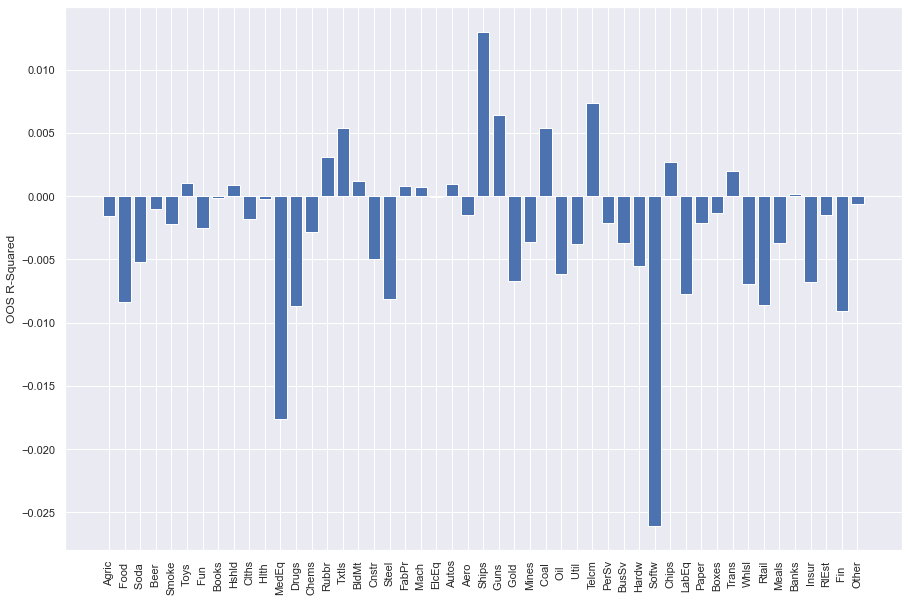

In [48]:
sns.set(rc={'figure.figsize':(15, 10)})
plt.bar(oos_rsquared_aqr.index, oos_rsquared_aqr['OOS R-Squared'])
plt.xticks(rotation='vertical')
plt.ylabel(r'OOS R-Squared')

plt.show()

### 4.1.b) Does the LPM do a good job of forecasting monthly returns? For which asset does it perform best? And worst?

The LPM does a very poor job forecasting monthly returns. It performs best for ships and worst for software.

### 4.1.c) Re-do the exercise using a window of 36 months. And 96 months. Do either of these windows work better?

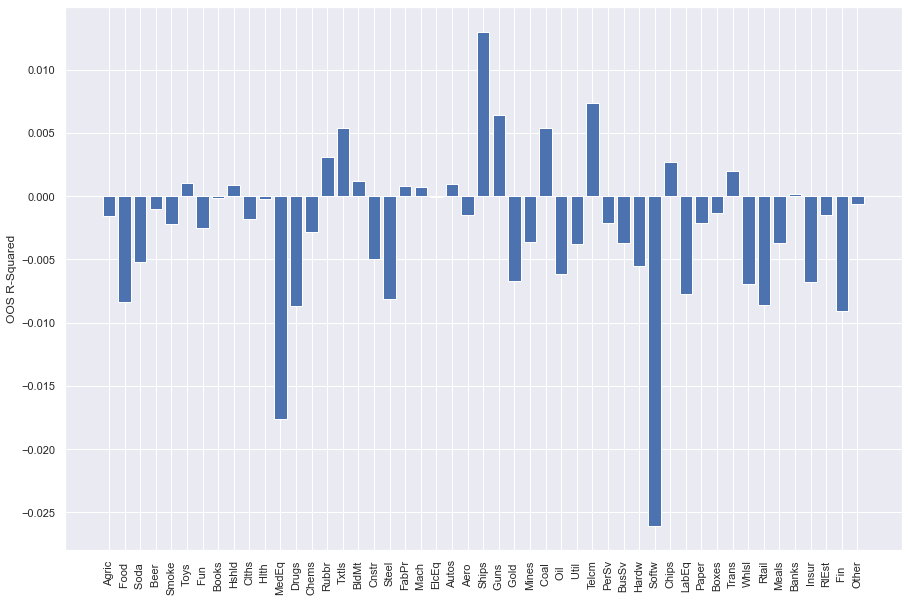

In [49]:
factor_aqr = factors.drop(['SMB','CMA'],axis = 1)
oos_rsquared_aqr_36 = oos_rsquare(factor_aqr,port_ret,rolling_window = 36)

sns.set(rc={'figure.figsize':(15, 10)})
plt.bar(oos_rsquared_aqr_36.index, oos_rsquared_aqr_36['OOS R-Squared'])
plt.xticks(rotation='vertical')
plt.ylabel(r'OOS R-Squared')

plt.show()

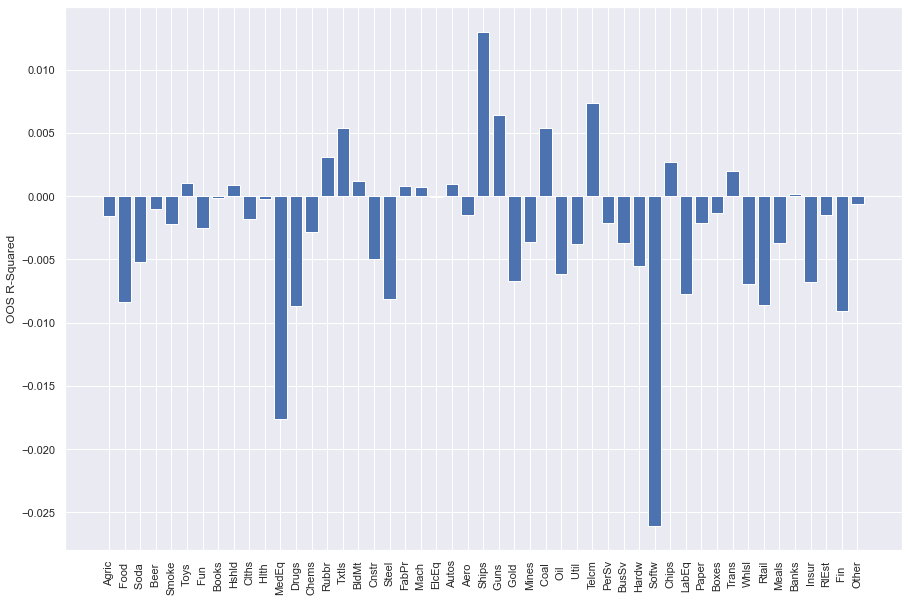

In [50]:
factor_aqr = factors.drop(['SMB','CMA'],axis = 1)
oos_rsquared_aqr_96 = oos_rsquare(factor_aqr,port_ret,rolling_window = 96)

sns.set(rc={'figure.figsize':(15, 10)})
plt.bar(oos_rsquared_aqr_96.index, oos_rsquared_aqr_96['OOS R-Squared'])
plt.xticks(rotation='vertical')
plt.ylabel(r'OOS R-Squared')

plt.show()

### 4.1.d) Re-do the exercise using the FF 5-Factor Model instead of the AQR model. Re-do it with the CAPM. Do either of these models improve on forecasting?

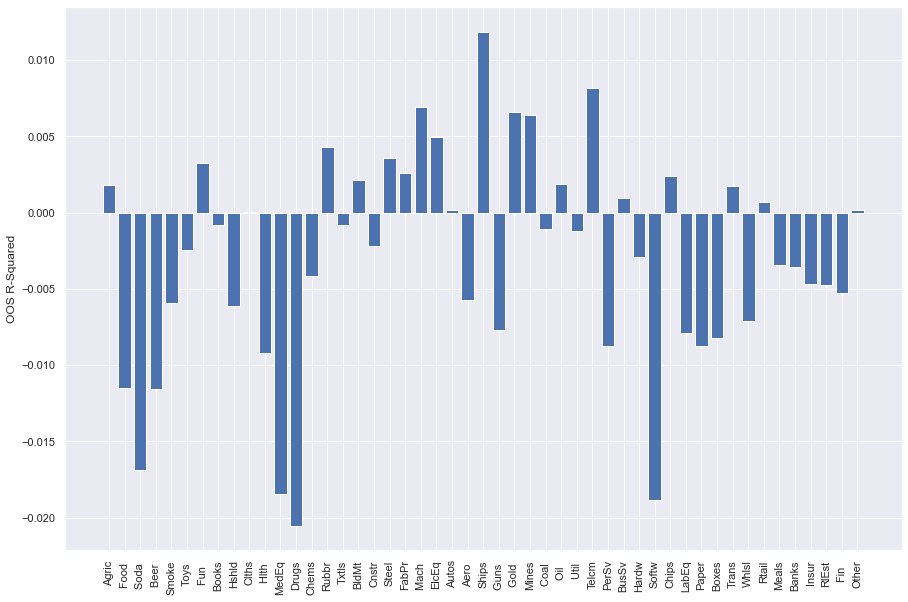

In [51]:
factor_ff5 = factors.drop(['UMD'],axis = 1)
oos_rsquared_ff5 = oos_rsquare(factor_ff5,port_ret,rolling_window = 60)

sns.set(rc={'figure.figsize':(15, 10)})
plt.bar(oos_rsquared_ff5.index, oos_rsquared_ff5['OOS R-Squared'])
plt.xticks(rotation='vertical')
plt.ylabel(r'OOS R-Squared')

plt.show()

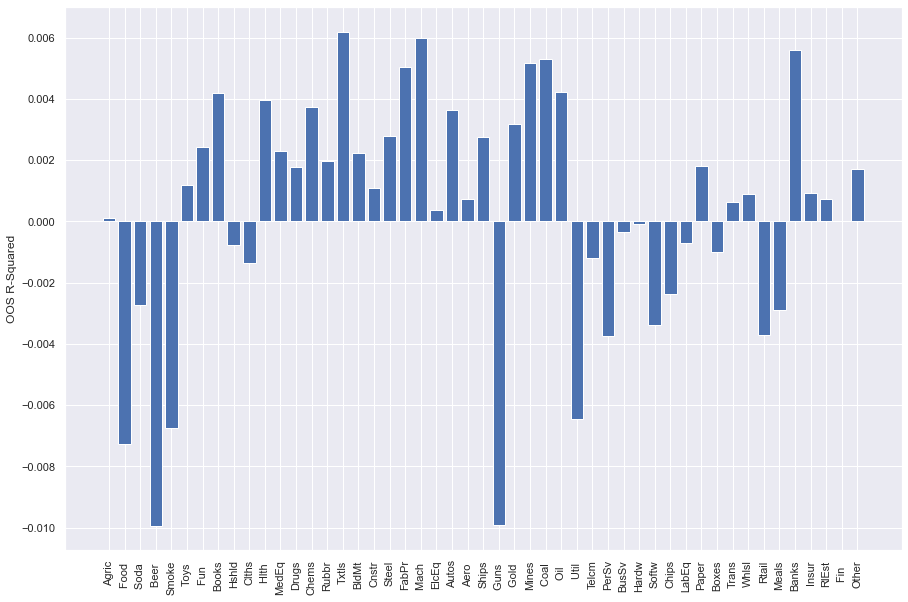

In [52]:
factor_capm = factors.loc[:,['MKT']]
oos_rsquared_capm = oos_rsquare(factor_capm,port_ret,rolling_window = 60)

sns.set(rc={'figure.figsize':(15, 10)})
plt.bar(oos_rsquared_capm.index, oos_rsquared_capm['OOS R-Squared'])
plt.xticks(rotation='vertical')
plt.ylabel(r'OOS R-Squared')

plt.show()

In [53]:
oos_rsquared_capm

,OOS R-Squared
Agric,0.000094
Food,-0.007283
Soda,-0.002746
Beer,-0.009941
Smoke,-0.006761
Toys,0.001200
Fun,0.002436
Books,0.004179
Hshld,-0.000774
Clths,-0.001374
